## Task1

1. The difficulties of the CSR format

The performance of the code based on CSR to compute the sparse matrix vector product (i.e. u=Av where A is the sparse matrix, u and v are the output and input vectors respectively) on GPUs is difficult to optimise due to the two drawbacks of the code:

1) Because of the indirect addressing of vector v, its access locality is not maintained. 
2) Since in the inner loop of the code the number of iterations of the inner loop is small and variable, the fine grained parallelism is not exploited.


2. How Ellpack and Ellpack-R solve these difficulties

1) Ellpack format

Ellpack format exploits two arrays to store the sparse matrix: one float A[ ], to save the entries, and one integer J[ ], to save the column index of every entry. Both arrays are of dimension N × Max_nzr at least, where N is the number of rows and Max_nzr is the maximum number of non-zeros per row in the matrix, with the maximum being taken over all rows. 

As for the sparse matrix-vector product(SpMV) on the GPU architecture, the arrays A[ ] and J[ ] store their elements in column-major order and every element i of vector u is computed by a thread identified by index x = i, so the SpMV based on ELLPACK can improve the computing performance because of fulfilling the conditions of coalesced global memory access with the column-major ordering storage of the data and non-synchronized execution between different thread blocks.

However, if the proportion of zeros is high in the ELLPACK data structure the performance decreases.



2) Ellpack-R format

ELLpack-R consists of two arrays A[ ] and J[ ] and an additional integer array rl[ ]: A[ ] (float) and J[ ] (integer) of dimension N × Max_nzr; rl[ ] of dimension N (i.e. the number of rows) is to store the number of non-zeros per row.

When T threads on a GPU compute the element u[i] accessing to the i-th row, the i-th row is split in sets of T elements. In order to compute the element u[i], T threads compute rl[ ] iterations of the inner loop of SpMV, every thread stores its partial computation in the shared memory. Finally, one reduction of the T values computed and stored in shared memory has to be included to generate the value of u[i].

The algorithms ELLpack-R to compute SpMV with GPUs have better performance due to: 1) Coalesced and aligned global memory access contributed by the column-major ordering used to store the matrix elements and the zeros-padding to complete the length of every row as multiple of 16. 2) Homogeneous computing within the warps. Since every thread executes the same loop, the code does not include flow instructions that cause serialization in warps. 3) There are not useless iterations and the control of loops of this implementation is reduced comparing with SpMV based on ELLPACK. 4) High occupancy levels are reached if optimal value of threads block size is used.

3. Developments of GPU based matvecs since that paper

There have been many developments of SpMV on GPUs in terms of SpMV data formats since 2010 when that paper was published. 

The bisection JAD (BiJAD) format [1] proposed in 2012 is an optimized and improved version of JAD [2] on GPUs. Two SpMV formats BRC and BCCOO proposed in 2014 alleviate the load imbalance caused by concurrent execution of many threads [3, 4]. In the same year, Kreutzer et al. proposed the SELL-C-σ format [6] which effectively reduces the number of zero-fillings. BiELL format [5] proposed by Zheng et al. is a bisection ELL format which  balances the workload of different threads in a warp, so reduces the waiting time. In 2016, AMB format [7] was proposed by Nagasaka et al. which aims to reduce the memory traffic in SpMV computation. In order to optimise the SpMV on GPUs, Wang et al proposed the PELLR format [8] in 2020 which improves ELLR format in performance of SpMV, but it also adds increased storage memory.


# Task2

1. Implement a new class EllpackMatrix which converts a Scipy sparse matrix in CSR format to Ellpack-R and provides a routine for matrix-vector product in the Ellpack-R format.

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import numba
from numba import cuda, float32, int64
from numba import prange
import scipy
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import LinearOperator


class EllpackMatrix(LinearOperator):
    
    def __init__(self, mtr):

        #convert data from the CSR matrix to the Ellpack-R
        
        self.data = mtr.data
        self.indices = mtr.indices
        self.indptr = mtr.indptr
        
        self.shape = mtr.shape
        self.dtype = mtr.dtype

        self.A, self.J, self.rl = csr_ellr(self.data, self.indices, self.indptr, self.dtype)

        # convert A and J to column-major arrays

        row_num = int(self.rl.shape[0])
        col_num = int(max(self.rl))
        A = np.reshape(self.A, row_num*col_num, order='F')
        J = np.reshape(self.J, row_num*col_num, order='F')

        # prepare data for cuda implementation

        self.A_global_mem = cuda.to_device(A)
        self.J_global_mem = cuda.to_device(J.astype('int64'))
        self.rl_global_mem = cuda.to_device(self.rl.astype('int64'))

        result = cuda.device_array((self.A.shape[0]))
        self.result_global_mem = cuda.to_device(result)
        cuda.synchronize()

        
    def _matvec(self, v):
      # define the function to support the LinearOperator operator

        TPB = 16
        
        v_global_mem = cuda.to_device(v)   
        nblocks = int(np.ceil(self.A.shape[0]/TPB))
        ell_matvec_cuda[(nblocks), (TPB)](self.A_global_mem, self.J_global_mem, v_global_mem, self.rl_global_mem,self.shape[0], self.result_global_mem)
        cuda.synchronize()

        result_global_gpu = self.result_global_mem.copy_to_host()

        return result_global_gpu


@cuda.jit   
def ell_matvec_cuda(A,J,v,rl,N,result):
  # implement the matrix-vector product in the Ellpack-R format on cuda

    x = cuda.grid(1)

    if x < N:
        temp = 0.0
        for k in range(rl[x]):
          j = J[k*N+x]
          temp += A[k*N+x]*v[j]
        result[x] = temp

    
@numba.njit(parallel=True)
def csr_ellr(data, indices, indptr, dtype):
  # convert CSR data format to Ellpack-R data format
    
    rl = np.zeros(indptr.shape[0]-1, dtype=dtype)
    
    for i in range(indptr.shape[0]-1): # construct the array rl
        temp = indptr[i+1] - indptr[i]
        rl[i] = temp
        
    row_num = int(rl.shape[0])
    col_num = int(max(rl))
    A = np.zeros(shape=(row_num,col_num),dtype=dtype)
    J = np.zeros(shape=(row_num,col_num),dtype=dtype)
    
    cnt = 0   
    for i in range(rl.shape[0]): # construct the A and J
        r = int(rl[i])
        for j in prange(r):
            A[i,j] = data[cnt+j]
            J[i,j] = indices[cnt+j]
        cnt += r
        
    return A,J,rl
    


2. Verify precision of the Ellpack-R matvec.

In [41]:
for i in range(3):
    
    csr_mat = scipy.sparse.random(1000, 1000, format='csr', dtype='float32')
    ell_mat = EllpackMatrix(csr_mat)
    
    v = np.random.randn(csr_mat.shape[1])
    
    y_ellr = ell_mat @ v
    y_csr = csr_mat @ v

    rel_dist = np.linalg.norm(y_ellr - y_csr, np.inf) / np.linalg.norm(y_csr, np.inf)
    print(f"Relative distance of Ellpack-R matvec product to CSR matvec product with v{i}: {round(rel_dist, 5)}.")

Relative distance of Ellpack-R matvec product to CSR matvec product with v0: 0.0.
Relative distance of Ellpack-R matvec product to CSR matvec product with v1: 0.0.
Relative distance of Ellpack-R matvec product to CSR matvec product with v2: 0.0.


3. Plot the times for a single matvec for growing matrix-sizes using the standard Scipy csr matvec and the above Ellpack-R implemementation.

In [42]:
def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

In [43]:
# implement SpMV on CSR and Ellpack-R and record times

N_list = [10,100,300,500,800,1000,2000,3000,4000,5000]
time_ellr = []
time_csr = []

for N in N_list:
    
    csr_mat, f = discretise_poisson(N)
    
    ell_mat = EllpackMatrix(csr_mat)
    v = np.random.randn(csr_mat.shape[1])
    
    timeit_result_ell = %timeit -o ell_mat @ v
    time_ellr.append(timeit_result_ell.best)
    
    timeit_result_csr = %timeit -o csr_mat @ v
    time_csr.append(timeit_result_csr.best)


The slowest run took 239.95 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 848 µs per loop
The slowest run took 9.14 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 7.96 µs per loop
1000 loops, best of 5: 1.03 ms per loop
The slowest run took 10.27 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 72.1 µs per loop
1000 loops, best of 5: 1.47 ms per loop
1000 loops, best of 5: 621 µs per loop
100 loops, best of 5: 2.1 ms per loop
1000 loops, best of 5: 1.72 ms per loop
100 loops, best of 5: 3.38 ms per loop
100 loops, best of 5: 4.64 ms per loop
100 loops, best of 5: 4.44 ms per loop
100 loops, best of 5: 8.5 ms per loop
100 loops, best of 5: 11.4 ms per loop
10 loops, best of 5: 36.9 ms per loop
10 loops, best of 5: 22.4 ms per loop
10 loops, best of 5: 85.5 ms per loop
10 loops, best of 5:

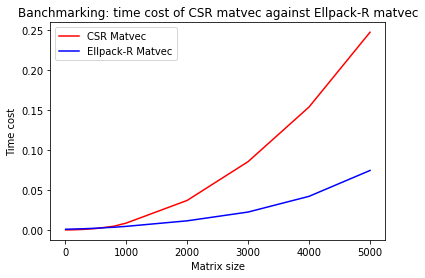

In [44]:
x = N_list
y1 = time_csr
y2 = time_ellr
plt.plot(x,y1,color = 'red',label = 'CSR Matvec')
plt.plot(x,y2,color = 'blue',label = 'Ellpack-R Matvec')
plt.title('Banchmarking: time cost of CSR matvec against Ellpack-R matvec')
plt.xlabel('Matrix size')
plt.ylabel('Time cost')
plt.legend()

From the plot, it can be seen that the speed of Ellpack-R matvec is lower than that of CSR when the matrix size N is lower than around 800. However, the Ellpack-R surpasses CSR in terms of the matvec speed when N is after around 800. Therefore, it can be induced that the Ellpack-R has better performance than CSR when the matrix size is large enough.

4. Compare Ellpack-R matvec times for two chosen matrices from the Matrix Market.

In [ ]:
# upload matrices data to colab

from google.colab import files
uploaded = files.upload()

In [28]:
# read data from mtx file

mm1 = mmread('bcsstk02.mtx')
mm2 = mmread('fidapm05.mtx')
mm3 = mmread('dw2048.mtx')
mm4 = mmread('rdb3200l.mtx')
mm5 = mmread('s1rmq4m1.mtx')
mm6 = mmread('fidap021.mtx')

In [29]:
# compute and compare times of Ellpack-R and CSR matvec for every matrix

mm6_csr = mm6.tocsr()
mm6_ellr = EllpackMatrix(mm6_csr)
v6 = np.random.randn(mm6_csr.shape[1])

timeit_result_ell = %timeit -o mm6_ellr @ v6
timeit_result_csr = %timeit -o mm6_csr @ v6

1000 loops, best of 5: 990 µs per loop
The slowest run took 25.00 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 35.4 µs per loop


In [30]:
mm5_csr = mm5.tocsr()
mm5_ellr = EllpackMatrix(mm5_csr)
v5 = np.random.randn(mm5_csr.shape[1])

timeit_result_ell = %timeit -o mm5_ellr @ v5
timeit_result_csr = %timeit -o mm5_csr @ v5

1000 loops, best of 5: 1.03 ms per loop
1000 loops, best of 5: 324 µs per loop


In [31]:
mm4_csr = mm4.tocsr()
mm4_ellr = EllpackMatrix(mm4_csr)
v4 = np.random.randn(mm4_csr.shape[1])

timeit_result_ell = %timeit -o mm4_ellr @ v4  
timeit_result_csr = %timeit -o mm4_csr @ v4

1000 loops, best of 5: 982 µs per loop
10000 loops, best of 5: 35.6 µs per loop


In [32]:
mm3_csr = mm3.tocsr()
mm3_ellr = EllpackMatrix(mm3_csr)
v3 = np.random.randn(mm3_csr.shape[1])

timeit_result_ell = %timeit -o mm3_ellr @ v3  
timeit_result_csr = %timeit -o mm3_csr @ v3

1000 loops, best of 5: 998 µs per loop
The slowest run took 19.80 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 23.1 µs per loop


In [33]:
mm2_csr = mm2.tocsr()
mm2_ellr = EllpackMatrix(mm2_csr)
v2 = np.random.randn(mm2_csr.shape[1])

timeit_result_ell = %timeit -o mm2_ellr @ v2  
timeit_result_csr = %timeit -o mm2_csr @ v2

1000 loops, best of 5: 968 µs per loop
The slowest run took 7.53 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 7.8 µs per loop


In [34]:
mm1_csr = mm1.tocsr()
mm1_ellr = EllpackMatrix(mm1_csr)
v1 = np.random.randn(mm1_csr.shape[1])

timeit_result_ell = %timeit -o mm1_ellr @ v1   
timeit_result_csr = %timeit -o mm1_csr @ v1

1000 loops, best of 5: 971 µs per loop
The slowest run took 57.42 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 11.9 µs per loop


None of the chosen matrices have better performance when implemented Ellpack-R format SpMV. I suppose there are two possible reasons: their matrix size is not large enough; they have few elements per row. But the excellent performance of the Ellpack-R matvec can be seen from the above plot. 

   
     
References:    
     
[1] Li, R. and Saad, Y. (2012) GPU-Accelerated Preconditioned Iterative Linear Solvers. The Journal of Supercomputing, 63, 443-466. https://doi.org/10.1007/s11227-012-0825-3
[2] Cenvahir, A., Nukada, A. and Matsuoka, S. (2009) Fast Conjugate Gradients with Multiple GPUs. Computational Science-ICCS 2009, 9th International Conference, Baton Rouge, LA, 25-27 May 2009, 893-903. https://doi.org/10.1007/978-3-642-01970-8_90
[3] S. Yan et al. yaSpMV: Yet Another SpMV Framework on GPUs. In Proceedings of the 19th ACM SIGPLAN Symposium on Principles and Practice of Parallel Programming, PPoPP ’14, 2014.
[4]  A. Ashari et al. An Efficient Two-dimensional Blocking Strategy for Sparse Matrix-vector Multiplication on GPUs. In Proceedings of the 28th ACM International Conference on Supercomputing, ICS ’14, pages 273–282, New York, NY, USA, 2014. ACM.
[5] M. Kreutzer et al. A Unified Sparse Matrix Data Format for Efficient General Sparse Matrix- Vector Multiplication on Modern Processors with Wide SIMD Units. SIAM Journal on Scientific Computing, 36(5):C401–C423, 2014.
[6] Zheng, C., Gu, S., Gu, T.-X. and Liu, X.-P. (2014) BiEll: A Bisection ELLPACK Based Storage Format for Optimizing SpMV on GPUs. Journal of Parallel and Dis- tributed Computing, 74, 2639-2647. https://doi.org/10.1016/j.jpdc.2014.03.002
[7] Yusuke Nagasaka, Akira Nukada, and and Satoshi Matsuoka. (2016) Adaptive Multi-level Blocking Optimization for Sparse Matrix Vector Multiplication on GPU. Procedia Computer Science, 80, 2016, Pages 131–142.
[8] Zhiqi Wang, Tongxiang Gu. (2020) PELLR: A Permutated ELLPACK-R Format for SpMV on GPUs. Journal of Computer and Communications, 2020, 8, 44-58.
https://www.scirp.org/journal/jcc
